<h2> Automatic filtering </h2> 

In [48]:
# import packages
import csv
import pandas as pd
import re
from bs4 import BeautifulSoup
import requests
import os
import numpy as np
import string
import math
from nltk import ngrams
import PyPDF2
import json
import time
import seaborn as sns
from matplotlib import pyplot as plt

In [49]:
# import internal modules
import file_path_management as fpath
import public_library as plib
import extract_info
import parameters as params
import download_and_process_pdf as dpp

<h3> Predefined fucntions: </h3> 

In [50]:
def info_filling(input_path, output_path, start, end):
    # scan each row in the potential related literature and extract information
    df = pd.read_csv(input_path, header=None, sep=",")
    df.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS"]

    for ind in range(start, end):
        # info = {
        #     "doi": np.nan,
        #     "pmid": np.nan,
        #     "pmcid": np.nan,
        #     "title": np.nan,
        #     "abstract": np.nan,
        #     "keywords": np.nan,
        #     "pdf_link": np.nan
        # }

        # initialzie
        index = df.at[ind, "INDEX"]
        doi = df.at[ind, "DOI"]
        pmid = df.at[ind, "PMID"]
        pmcid = df.at[ind, "PMCID"]
        full_text_url = df.at[ind, "FULL_TEXT_URL"]
        full_text_source = df.at[ind, "FULL_TEXT_SOURCE"]
        pdf_url = np.nan
        pdf_source = np.nan
        title = df.at[ind, "TITLE"]
        abstract = df.at[ind, "ABSTRACT"]
        keywords = df.at[ind, "KEYWORDS"]

        if full_text_url != full_text_url: # full text url not found
            if df.at[ind, "PDF_URL"] == df.at[ind, "PDF_URL"]:
                url = str(df.at[ind, "PDF_URL"]).strip()
                url1, status_code = plib.get_final_redirected_url(url)
                if status_code == 200:
                    pdf_url = url
                    pdf_source = pdf_url.split("://")[1].split("/")[0]
                elif status_code == 403:
                    # print(status_code, "when getting final redirected url: ", url)
                    pdf_url = url
                    pdf_source = pdf_url.split("://")[1].split("/")[0]
                else:
                    print(status_code, "when getting final redirected url: ", url)
                    pdf_url = np.nan
                    pdf_source = np.nan  
            else:
                print("full text url and pdf url are not available!")
                pdf_url = np.nan
                pdf_source = np.nan
        elif ('.pdf' in full_text_url and full_text_url.split('.pdf')[1] == '') or ('.PDF' in full_text_url and full_text_url.split('.PDF')[1] == ''):
            print("full text url is a pdf file: ", full_text_url)
            pdf_url = full_text_url
            pdf_source = full_text_source
            full_text_url = np.nan
            full_text_source = np.nan
        else: # full text url found
            flag = False
            for website in params.websites:
                if website in full_text_source:
                    flag = True
                    break
            if not flag:
                continue

            url = str(full_text_url).strip()
            try:
                info = extract_info.extract_info_from_webpage(url, params.websites)
            except:
                raise Exception("Error! Cannot extract information from the webpage: ", url)
            
            # doi
            if info['doi'] == info['doi'] and doi == doi and info['doi'] != doi:
                print(doi)
                print(info['doi'])

            if info['doi'] == info['doi']:
                doi = info['doi'].lower()
            else:
                doi = doi
            
            # pmid
            if info['pmid'] == info['pmid'] and df.at[ind, "PMID"] == df.at[ind, "PMID"] and str(int(info['pmid'])) != str(int(df.at[ind, "PMID"])):
                print(str(int(df.at[ind, "PMID"]))) 
                print(str(int(info['pmid'])))      

            if info['pmid'] == info['pmid']:
                pmid = str(int(info['pmid']))
            elif pmid == pmid:
                pmid = str(int(pmid)).strip()
            else:
                pmid = np.nan
            
            # pmcid
            if info['pmcid'] == info['pmcid'] and pmcid == pmcid and info['pmcid'] != pmcid:
                print(pmcid)
                print(info['pmcid'])

            if info['pmcid'] == info['pmcid']:
                pmcid = info['pmcid']
            else:
                pmcid = df.at[ind, "PMCID"]
            
            # full_text_url, full_text_surce
            if full_text_url == full_text_url:
                full_text_source = full_text_url.split("://")[1].split("/")[0]
            else:
                print("full text url is not available")
                full_text_url = np.nan
                full_text_source = np.nan

            if pdf_url != pdf_url and info['pdf_link'] == info['pdf_link']:
                pdf_url = str(info['pdf_link']).strip()
                pdf_source = pdf_url.split("://")[1].split("/")[0]
                # try:
                #     pdf_url, status_code = plib.get_final_redirected_url(url)
                #     if status_code == 200:
                #         pdf_source = pdf_url.split("://")[1].split("/")[0]
                #     elif status_code == 403:
                #         # print(status_code, "when getting final redirected url: ", url)
                #         pdf_source = pdf_url.split("://")[1].split("/")[0]
                #     else:
                #         print(status_code, "when getting final redirected url: ", url)
                #         pdf_url = np.nan
                #         pdf_source = np.nan
                # except:
                #     pdf_url = np.nan
                #     pdf_source = np.nan 
                    
            if pdf_url != pdf_url and df.at[ind, "PDF_URL"] == df.at[ind, "PDF_URL"]:
                print("PDF_URL not extracted from info: , but existed already: ", df.at[ind, "PDF_URL"])
                pdf_url = df.at[ind, "PDF_URL"]
                pdf_source = pdf_url.split("://")[1].split("/")[0]
            
            if pdf_url != pdf_url:
                if full_text_url == full_text_url and full_text_url.split("://")[1].split("/")[0] == 'www.ncbi.nlm.nih.gov':
                    if doi == doi:
                        url = "https://doi.org/" + doi
                        url, status_code = plib.get_final_redirected_url(url)
                        info = extract_info.extract_info_from_webpage(url, params.websites)
                        full_text_url = url
                        full_text_source = url.split("://")[1].split("/")[0]
                        pdf_url = info["pdf_link"]
                        pdf_source = pdf_url.split("://")[1].split("/")[0]
                    else:
                        pdf_url = np.nan
                        pdf_source = np.nan
                else:  
                    print("PDF_URL not found for: ", doi, pmid, pmcid, full_text_url)
                    pdf_url = np.nan
                    pdf_source = np.nan
                
            # title
            if info['title'] == info['title']:
                title = info['title']
                title = title.replace(";", ",")
            else:
                title = title
            
            # abstract
            if info['abstract'] == info['abstract']:
                abstract = info['abstract']
                abstract = ''.join(e for e in abstract if (e.isalpha() or e == " " or e == "-"))
            else:
                abstract = abstract
            
            # keywords
            if info['keywords'] == info['keywords']:
                keywords = info['keywords']
                keywords = keywords.replace(";", ",")
                keywords = ''.join(e for e in keywords if (e.isalpha() or e == " " or e == "-" or e == ","))
            else:
                keywords = keywords
        
        columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS"]
        
        row = {
            "INDEX": [index],
            "DOI": [doi],
            "PMID": [pmid],
            "PMCID": [pmcid],
            "FULL_TEXT_URL": [full_text_url],
            "FULL_TEXT_SOURCE": [full_text_source],
            "PDF_URL": [pdf_url],
            "PDF_SOURCE": [pdf_source],
            "TITLE": [title],
            "ABSTRACT": [abstract],
            "KEYWORDS": [keywords]
        }
        # print(row)

        if not plib.add_row_to_csv(output_path, row, columns):
            print("Error detected when adding a row to csv!")
        
        print(ind)
# --------------------start of test code--------------------
# input_path = fpath.poten_litera_ids_ftl_filled
# output_path = fpath.poten_litera_litera_db

# # clear file
# plib.clear_file(output_path)

# info_filling(input_path, output_path)
# ---------------------end of test code---------------------

In [51]:
def download_pdf(input_path, pdf_folder, start, end):
    df = pd.read_csv(input_path, header=None, sep=',')
    df.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS"]

    for ind in range(start, end):
        # time.sleep(3)
        
        # the flag to indicate whether the pdf is downloaded successfully, if not, save the row to poten_litera_pdf_not_available.csv
        flag = False

        pdf_url = df.at[ind, "PDF_URL"]

        # pdf_url not found
        if pdf_url != pdf_url:
            flag = False
        # pdf_url found
        else:
            doi = df.at[ind, "DOI"]
            if dpp.download_and_rename_pdf(pdf_url, doi, df.at[ind, "INDEX"], pdf_folder):
                flag = True
            else:
                print(df.at[ind, "FULL_TEXT_URL"])
                flag = False

        # # pdf_url not found
        # if pdf_url != "://linkinghub.elsevier.com/":
        #     continue
        # # pdf_url found
        # else:
        #     doi = df.at[ind, "DOI"]
        #     if dpp.download_and_rename_pdf(pdf_url, doi, df.at[ind, "INDEX"], pdf_folder):
        #         flag = True
        #     else:
        #         print(df.at[ind, "FULL_TEXT_URL"])
        #         flag = False
        
        if not flag:
            print("PDF_URL not found or PDF not successfully downloaded for: ")
            print("\n")
            print(df.at[ind, "INDEX"], df.at[ind, "DOI"], df.at[ind, "PMID"], df.at[ind, "PMCID"], df.at[ind, "FULL_TEXT_URL"], df.at[ind, "FULL_TEXT_SOURCE"], df.at[ind, "PDF_URL"], df.at[ind, "PDF_SOURCE"], df.at[ind, "TITLE"], df.at[ind, "ABSTRACT"], df.at[ind, "KEYWORDS"])
            # print("\n")

        line_number_in_csv = ind + 1
        print(ind, " Line number:", line_number_in_csv, " INDEX:", int(df.at[ind, "INDEX"]))
        print("\n")

In [52]:
def pdf2text(pdf_path, text_path, start_page, text_length_to_extract):    
    try:
        # creating a pdf reader object
        reader = PyPDF2.PdfReader(pdf_path)
        
        # printing number of pages in pdf file
        page_max = len(reader.pages)
        # print(page_max)
        
        # getting a specific page from the pdf file
        text = ""
        
        for i in range(start_page, page_max):
            page = reader.pages[i]
            text = text + " ".join(page.extract_text().splitlines())
            if len(text.split()) > text_length_to_extract:
                break

        with open(text_path, "w") as f:
            f.write(text)
        f.close()
        
        return True
    except:
        return False
# --------------------start of test code--------------------
# index = 1
# pdf_folder = fpath.pdf_folder
# text_folder = fpath.text_folder
# start_page = 0
# end_page = 5
# text_length_to_extract = 1000

# pdf_file_name = str(index) + ".pdf"
# pdf_path = os.path.join(pdf_folder, pdf_file_name)
# text_path = os.path.join(text_folder, pdf_file_name.split(".pdf")[0] + ".txt")
# # print(pdf_path)
# # print(text_path)
# pdf2text(pdf_path, text_path, start_page, text_length_to_extract)
# ---------------------end of test code---------------------

In [53]:
def json2text(json_path, text_path, text_length_to_extract):    
    with open(json_path, "r") as f:
        json_file = json.load(f)
        text = json_file["full-text-retrieval-response"]["originalText"]
    f.close()

    title = json_file["full-text-retrieval-response"]["coredata"]["dc:title"]

    text = title + " " + text.split(title)[1]

    words = text.split()
    text = ' '.join(words[:text_length_to_extract])

    with open(text_path, "w") as f:
        f.write(text)
    f.close()
# --------------------start of test code--------------------
# index = 1
# pdf_folder = fpath.pdf_folder
# text_folder = fpath.text_folder
# start_page = 0
# text_length_to_extract = 1000

# json_file_name = str(index) + ".json"
# json_path = os.path.join(pdf_folder, json_file_name)
# text_path = os.path.join(text_folder, str(index) + ".txt")
# # print(pdf_path)
# # print(text_path)
# json2text(json_path, text_path, text_length_to_extract)
# ---------------------end of test code---------------------

In [54]:
def count_keyword(text, keyword, keyword_length):
    # remove non-alphabetic characters but keep spaces and "-"
    text = ''.join(e for e in text if (e.isalpha() or e == " " or e == "-"))
    # print(text)
    text = text.strip().lower()
    # print(text)
    
    words = []
    n = keyword_length
    n_grams = ngrams(text.split(), n)
    for gram in n_grams:
        word = gram[0]
        if n > 0:
            for i in range(1, n):
                word = word + " " + gram[i]
        words.append(word)
    # print(words)
    
    word_count = 0
    for word in words:
        # print(word)
        if word == keyword:
            word_count += 1
    return word_count
# --------------------start of test code--------------------
# # text = 'This apple 6i7s very tasty？、  2but th&e banana this is not delicious at Is all.6'
# text = "Distribution of the dopamine innervation in the macaque and human thalamus Miguel Ángel García-Cabezas,aBeatriz Rico,a,b Miguel Ángel Sánchez-González,aand Carmen Cavadaa,⁎ aDepartamento de Anatomía, Histología y Neurociencia, Facultad de Medicina, Universidad Autónoma de Madrid, C/Arzobispo Morcillo s/n, 28029 Madrid, Spain bInstituto de Neurociencias de Alicante, Universidad Miguel Hernández-CSIC, 03550 Sant Joan d ’Alacant, Spain Received 19 April 2006; revised 8 June 2006; accepted 11 July 2006 Available online 30 November 2006 We recently defined the thalamic dopaminergic system in primates; it arises from numerous dopaminergic cell groups and selectively targetsnumerous thalamic nuclei. Given the central position of the thalamus in subcortical and cortical interplay, and the functional relevance of dopamine neuromodulation in the brain, detailing dopamine dis-tribution in the thalamus should supply important information. Tothis end we performed immunohistochemistry for dopamine and the dopamine transporter in the thalamus of macaque monkeys and humans to generate maps, in the stereotaxic coronal plane, of thedistribution of dopaminergic axons. The dopamine innervation of the thalamus follows the same pattern in both species and is most dense in midline limbic nuclei, the mediodorsal and lateral posteriorassociation nuclei, and in the ventral lateral and ventral anteriormotor nuclei. This distribution suggests that thalamic dopamine has a prominent role in emotion, attention, cognition and complex somatosensory and visual processing, as well as in motor control.Most thalamic dopaminergic axons are thin and varicose and targetboth the neuropil and small blood vessels, suggesting that, besides neuronal modulation, thalamic dopamine may have a direct influence on microcirculation. The maps provided here should be a usefulreference in future experimental and neuroimaging studies aiming atclarifying the role of the thalamic dopaminergic system in health and in conditions involving brain dopamine, including Parkinson ’s disease, drug addiction and schizophrenia.© 2006 Elsevier Inc. All rights reserved. Keywords: Dopamine; Thalamus; Monkey; Human; Primate; Dopamine transporter; Parkinson; Schizophrenia; AddictionIntroduction The thalamus is made up of multiple nuclei relaying information from subcortical centers or from other cortices to the cerebral cortex (Sherman and Guillery, 2005 ), as well as the striatum, the nucleus accumbens and the amygdala ( Steriade et al., 1997 ). In addition to specific subcortical and cortical afferents, the primate thalamus receives axons containing the neuromodulators acetylcholine (Heckers et al., 1992 ), histamine ( Manning et al., 1996 ), serotonin (Morrison and Foote, 1986; Lavoie and Parent, 1991 ), and the catecholamines adrenaline ( Rico and Cavada, 1998a ), noradrenaline (Morrison and Foote, 1986; Ginsberg et al., 1993 ) and dopamine (Sánchez-González et al., 2005 ). Until recently, the existence of significant dopamine innervation in the primate thalamus has been largely ignored, probably becausedopamine innervation of the rodent thalamus is very scant(Groenewegen, 1988; Papadopoulos and Parnavelas, 1990 ). However, fragmentary data scattered through the literature endorse the presence of dopamine innervation in the primate thalamus.Postmortem biochemical studies showed the presence of dopamine in the thalamus of macaques ( Brown et al., 1979; Goldman-Rakic and Brown, 1981; Pifl et al., 1990, 1991 ) and human subjects ( Oke and Adams, 1987 ). Later, receptor binding and in situ hybridization analyses detected the presence of dopamine D2-like ( Joyce et al., 1991; Kessler et al., 1993; Hall et al., 1996; Langer et al., 1999;Rieck et al., 2004 ) and D3-like receptors ( Gurevich and Joyce, 1999 ) in several human thalamic nuclei. Positron emission tomography (PET) radioligand studies have also demonstratedthe presence of the dopamine transporter (DAT) ( Wang et al., 1995; Halldin et al., 1996; Helfenbein et al., 1999; Brownell et al., 2003 ) and of D2-like receptors ( Farde et al., 1997; Langer et al., 1999; Okubo et al., 1999; Brownell et al., 2003; Rieck et al., 2004 ) in the human and macaque thalamus. In the course of PET studies focusing on schizophrenia, D2- and D3-like radioligand binding was also found in the thalamus of control subjects ( Talvik et al., 2003; Yasuno et al., 2004 ). Finally, an immunohistochemical study using anti-DAT antibodies detected the presence of dopaminergic www.elsevier.com/locate/ynimg NeuroImage 34 (2007) 965 –984 ⁎Corresponding author. Fax: +34 91 497 53 15. E-mail address: carmen.cavada@uam.es (C. Cavada). Available online on ScienceDirect (www.sciencedirect.com). 1053-8119/$ - see front matter © 2006 Elsevier Inc. All rights reserved. doi:10.1016/j.neuroimage.2006.07.032"
# keyword = 'macaque'
# count = count_keyword(text, keyword, len(keyword.split()))
# print(count)
# ---------------------end of test code---------------------

In [55]:
def count_on_topic_kws_from_liter(text_tak, text_txt, on_topic_kws, type):
    text_tak = ''.join(e for e in text_tak if (e.isalpha() or e == " " or e == "-"))
    text_tak = text_tak.strip().lower()
    text_tak = ' '.join(text_tak.split())
    # print(text_tak)

    text_txt = ''.join(e for e in text_txt if (e.isalpha() or e == " " or e == "-"))
    text_txt = text_txt.strip().lower()
    text_txt = ' '.join(text_txt.split())
    # print(text_txt)

    text_text = text_tak + " " + text_txt

    length_tak = len(text_tak.split())
    length_txt = len(text_txt.split())
    length_text = length_tak + length_txt

    keywords_count = dict()
    keywords_freq = dict()

    # count the on-topic keywords
    for i in range(len(on_topic_kws)):
        # print(on_topic_kws[i])
        word_count = count_keyword(text_text, on_topic_kws[i], len(on_topic_kws[i].split()))
        # print(word_count)
        if type == "freq":
            keywords_freq[on_topic_kws[i]] = round(word_count * 10 / length_text, 2)
        elif type == "count":
            keywords_count[on_topic_kws[i]] = word_count
        else:
            print("Error! Wrong type!")
    # print(keywords_count)
    return length_tak, length_txt, length_text, keywords_freq
# --------------------start of test code--------------------
# text_tak = 'Vision for action: thalamic and cortical inputs to the macaque superior tract neural tracing, parietal lobule The dorsal visual stream, the cortical circuit that in the primate brain is mainly dedicated to the visual control of actions, is split into two routes, a lateral and a medial one, both involved in coding different aspects of sensorimotor control of actions. The lateral route, named "lateral grasping network", is mainly involved in the control of the distal part of prehension, namely grasping and manipulation. The medial route, named "reach-to-grasp network", is involved in the control of the full deployment of prehension act, from the direction of arm movement to the shaping of the hand according to the object to be grasped. In macaque monkeys, the reach-to-grasp network (the target of this review) includes areas of the superior parietal lobule (SPL) that hosts visual and somatosensory neurons well suited to control goal-directed limb movements toward stationary as well as moving objects. After a brief summary of the neuronal functional properties of these areas, we will analyze their cortical and thalamic inputs thanks to retrograde neuronal tracers separately injected into the SPL areas V6, V6A, PEc, and PE. These areas receive visual and somatosensory information distributed in a caudorostral, visuosomatic trend, and some of them are directly connected with the dorsal premotor cortex. This review is particularly focused on the origin and type of visual information reaching the SPL, and on the functional role this information can play in guiding limb interaction with objects in structured and dynamic environments. Area PEc; Area V6; Area V6A; Dorsal visual stream; Goal-directed arm movement; Sensorimotor integration.'
# text_txt = "Distribution of the dopamine innervation in the macaque and human thalamus Miguel Ángel García-Cabezas,aBeatriz Rico,a,b Miguel Ángel Sánchez-González,aand Carmen Cavadaa,⁎ aDepartamento de Anatomía, Histología y Neurociencia, Facultad de Medicina, Universidad Autónoma de Madrid, C/Arzobispo Morcillo s/n, 28029 Madrid, Spain bInstituto de Neurociencias de Alicante, Universidad Miguel Hernández-CSIC, 03550 Sant Joan d ’Alacant, Spain Received 19 April 2006; revised 8 June 2006; accepted 11 July 2006 Available online 30 November 2006 We recently defined the thalamic dopaminergic system in primates; it arises from numerous dopaminergic cell groups and selectively targetsnumerous thalamic nuclei. Given the central position of the thalamus in subcortical and cortical interplay, and the functional relevance of dopamine neuromodulation in the brain, detailing dopamine dis-tribution in the thalamus should supply important information. Tothis end we performed immunohistochemistry for dopamine and the dopamine transporter in the thalamus of macaque monkeys and humans to generate maps, in the stereotaxic coronal plane, of thedistribution of dopaminergic axons. The dopamine innervation of the thalamus follows the same pattern in both species and is most dense in midline limbic nuclei, the mediodorsal and lateral posteriorassociation nuclei, and in the ventral lateral and ventral anteriormotor nuclei. This distribution suggests that thalamic dopamine has a prominent role in emotion, attention, cognition and complex somatosensory and visual processing, as well as in motor control.Most thalamic dopaminergic axons are thin and varicose and targetboth the neuropil and small blood vessels, suggesting that, besides neuronal modulation, thalamic dopamine may have a direct influence on microcirculation. The maps provided here should be a usefulreference in future experimental and neuroimaging studies aiming atclarifying the role of the thalamic dopaminergic system in health and in conditions involving brain dopamine, including Parkinson ’s disease, drug addiction and schizophrenia.© 2006 Elsevier Inc. All rights reserved. Keywords: Dopamine; Thalamus; Monkey; Human; Primate; Dopamine transporter; Parkinson; Schizophrenia; AddictionIntroduction The thalamus is made up of multiple nuclei relaying information from subcortical centers or from other cortices to the cerebral cortex (Sherman and Guillery, 2005 ), as well as the striatum, the nucleus accumbens and the amygdala ( Steriade et al., 1997 ). In addition to specific subcortical and cortical afferents, the primate thalamus receives axons containing the neuromodulators acetylcholine (Heckers et al., 1992 ), histamine ( Manning et al., 1996 ), serotonin (Morrison and Foote, 1986; Lavoie and Parent, 1991 ), and the catecholamines adrenaline ( Rico and Cavada, 1998a ), noradrenaline (Morrison and Foote, 1986; Ginsberg et al., 1993 ) and dopamine (Sánchez-González et al., 2005 ). Until recently, the existence of significant dopamine innervation in the primate thalamus has been largely ignored, probably becausedopamine innervation of the rodent thalamus is very scant(Groenewegen, 1988; Papadopoulos and Parnavelas, 1990 ). However, fragmentary data scattered through the literature endorse the presence of dopamine innervation in the primate thalamus.Postmortem biochemical studies showed the presence of dopamine in the thalamus of macaques ( Brown et al., 1979; Goldman-Rakic and Brown, 1981; Pifl et al., 1990, 1991 ) and human subjects ( Oke and Adams, 1987 ). Later, receptor binding and in situ hybridization analyses detected the presence of dopamine D2-like ( Joyce et al., 1991; Kessler et al., 1993; Hall et al., 1996; Langer et al., 1999;Rieck et al., 2004 ) and D3-like receptors ( Gurevich and Joyce, 1999 ) in several human thalamic nuclei. Positron emission tomography (PET) radioligand studies have also demonstratedthe presence of the dopamine transporter (DAT) ( Wang et al., 1995; Halldin et al., 1996; Helfenbein et al., 1999; Brownell et al., 2003 ) and of D2-like receptors ( Farde et al., 1997; Langer et al., 1999; Okubo et al., 1999; Brownell et al., 2003; Rieck et al., 2004 ) in the human and macaque thalamus. In the course of PET studies focusing on schizophrenia, D2- and D3-like radioligand binding was also found in the thalamus of control subjects ( Talvik et al., 2003; Yasuno et al., 2004 ). Finally, an immunohistochemical study using anti-DAT antibodies detected the presence of dopaminergic www.elsevier.com/locate/ynimg NeuroImage 34 (2007) 965 –984 ⁎Corresponding author. Fax: +34 91 497 53 15. E-mail address: carmen.cavada@uam.es (C. Cavada). Available online on ScienceDirect (www.sciencedirect.com). 1053-8119/$ - see front matter © 2006 Elsevier Inc. All rights reserved. doi:10.1016/j.neuroimage.2006.07.032"
# on_topic_kws = [key for key in params.on_topic_kws_weights.keys()]
# keywords_count = count_on_topic_kws_from_liter(text_tak, text_txt, on_topic_kws)
# print(keywords_count)
# ---------------------end of test code---------------------

In [56]:
def calcul_index(keywords_count, on_topic_kws_weights):
    index = 0
    for key in keywords_count.keys():
        index += keywords_count[key] * on_topic_kws_weights[key]
    return index
# --------------------start of test code--------------------
# keywords_count_or_fre = {}
# index = calcul_related(keywords_count_or_fre, params.on_topic_kws_weights)
# print(index)
# ---------------------end of test code---------------------

In [57]:
def weight_and_rank(input_path, output_path, on_topic_kws_weights):
    df = pd.read_csv(input_path, header=None, sep=",")
    df.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS"]

    for ind in df.index:
        index = str(int(df.at[ind, "INDEX"]))
        txt_file_name = str(index) + ".txt"
        txt_path = os.path.join(fpath.text_folder, txt_file_name)

        text_tak = ""
        text_txt = ""
        if df.at[ind, "TITLE"] == df.at[ind, "TITLE"]:
            text_tak = text_tak + " " + df.at[ind, "TITLE"]
        if df.at[ind, "ABSTRACT"] == df.at[ind, "ABSTRACT"]:
            text_tak = text_tak + " " + df.at[ind, "ABSTRACT"]
        if df.at[ind, "KEYWORDS"] == df.at[ind, "KEYWORDS"]:
            text_tak = text_tak + " " + df.at[ind, "KEYWORDS"]
        # print(text)

        if os.path.exists(txt_path):
            with open(txt_path, "r") as f:
                text_txt = f.read()
            f.close()
        else:
            print(".txt file not found:", ind, index, df.at[ind, "PDF_URL"])
        
        on_topic_kws = [key for key in on_topic_kws_weights.keys()]
        # length_tak, length_txt, length_text, keywords_count = count_on_topic_kws_from_liter(text_tak, text_txt, on_topic_kws, "count")
        length_tak, length_txt, length_text, keywords_freq = count_on_topic_kws_from_liter(text_tak, text_txt, on_topic_kws, "freq")

        # relev_index = calcul_index(keywords_count, on_topic_kws_weights)
        relev_index = calcul_index(keywords_freq, on_topic_kws_weights)
        # print(index)

        columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", 
                   "TITLE", "ABSTRACT", "KEYWORDS", 
                   "LENGTH_TAK", "LENGTH_TXT", "LENGTH_TEXT","RELEVANCE_INDEX"]
        
        # columns = columns + [key for key in keywords_count.keys()]

        row = {
            "INDEX": [df.at[ind, "INDEX"]],
            "DOI": [df.at[ind, "DOI"]],
            "PMID": [df.at[ind, "PMID"]],
            "PMCID": [df.at[ind, "PMCID"]],
            "FULL_TEXT_URL": [df.at[ind, "FULL_TEXT_URL"]],
            "FULL_TEXT_SOURCE": [df.at[ind, "FULL_TEXT_SOURCE"]],
            "PDF_URL": [df.at[ind, "PDF_URL"]],
            "PDF_SOURCE": [df.at[ind, "PDF_SOURCE"]],
            "TITLE": [df.at[ind, "TITLE"]],
            "ABSTRACT": [df.at[ind, "ABSTRACT"]],
            "KEYWORDS": [df.at[ind, "KEYWORDS"]],
            "LENGTH_TAK": [length_tak],
            "LENGTH_TXT": [length_txt],
            "LENGTH_TEXT": [length_text],
            "RELEVANCE_INDEX": [relev_index]
        }
        
        # for key in on_topic_kws:
        #     row[key] = [keywords_count[key]]
        # print(row)

        if not plib.add_row_to_csv(output_path, row, columns):
            print("Error detected when adding a row to csv!")
        
        # line_number_in_csv = ind + 1
        # print("Line number:", line_number_in_csv, " INDEX:", int(df.at[ind, "INDEX"]))

    # rank
    df_ranked = pd.read_csv(output_path, header=0, sep=",")
    df_ranked.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", 
                   "TITLE", "ABSTRACT", "KEYWORDS", 
                   "LENGTH_TAK", "LENGTH_TXT", "LENGTH_TEXT","RELEVANCE_INDEX"]
    df_ranked = df_ranked.sort_values(by="RELEVANCE_INDEX", ascending=False)
    df_ranked.reset_index(drop=True, inplace=True)
    df_ranked.to_csv(output_path, header=True, index=False)
    print("Weighting and ranking the potentially related literature succeded!")
    print("Enjoy reading!")
# --------------------start of test code--------------------
# input_path = fpath.poten_litera_litera_db
# output_path = fpath.poten_litera_litera_db_ranked
# weight_and_rank(input_path, output_path)
# ---------------------end of test code---------------------

<h3> Main program: </h3> 

In [58]:
# # # process, correct the INDEX in potential_related_literature_testing_set_300_read.csv
# # input_path = fpath.poten_litera_testing_set_300_read
# # output_path = fpath.poten_litera_testing_set_300_read_index_corrected
# # plib.clear_file(output_path)
# # db_path = fpath.poten_litera_litera_db

# # df_input = pd.read_csv(input_path, header=0, sep=',')
# # df_input.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS", "RELEVANCE"]
# # df_db = pd.read_csv(db_path, header=None, sep=',')
# # df_db.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS"]
# # df_db = df_db.fillna(0)
# # df_db = df_db.astype({"PMID": int})
# # # print(df_input.shape)
# # # print(df_input.head(5))
# # # (300, 12)
# # # print(df_db.shape)
# # # print(df_db.head(10))
# # # (10776, 11)

# # for ind in df_input.index:
# #     index = df_input.at[ind, "INDEX"]
# #     doi = df_input.at[ind, "DOI"]
# #     pmid = df_input.at[ind, "PMID"]
# #     # print(pmid, df_db.at[ind, "PMID"])
# #     # print(pmid.type(), df_db.at[ind, "PMID"].type())
# #     pmcid = df_input.at[ind, "PMCID"]
# #     full_text_url = df_input.at[ind, "FULL_TEXT_URL"]
# #     full_text_source = df_input.at[ind, "FULL_TEXT_SOURCE"]
# #     title = df_input.at[ind, "TITLE"].lower()

# #     if doi == doi:
# #         try:
# #             index = df_db.loc[df_db["DOI"] == doi, 'INDEX'].values[0]
# #             df_input.at[ind, "INDEX"] = index
# #         except:
# #             print("DOI not found in db:", df_input.at[ind, "INDEX"], df_input.at[ind, "RELEVANCE"])
# #             df_input.drop(ind, inplace=True)
# #     elif pmid == pmid:
# #         try:
# #             index = df_db.loc[df_db["PMID"]==int(pmid), 'INDEX'].values[0]
# #             df_input.at[ind, "INDEX"] = index
# #         except:
# #             print("PMID not found in db:", df_input.at[ind, "INDEX"], df_input.at[ind, "RELEVANCE"])
# #             df_input.drop(ind, inplace=True)
# #     elif pmcid == pmcid:
# #         index = df_db.loc[df_db["PMCID"] == pmcid, 'INDEX'].values[0]
# #         df_input.at[ind, "INDEX"] = index
# #     elif title.lower() == title.lower():
# #         index = df_db.loc[df_db["TITLE"].str.lower() == title, 'INDEX'].values[0]
# #         df_input.at[ind, "INDEX"] = index
# #     else:
# #         print("ALL 4 identifiers and title are missing:", df_input.at[ind, "INDEX"], df_input.at[ind, "RELEVANCE"])
    
# # df_input.reset_index(drop=True, inplace=True)
# # df_input.to_csv(output_path, header=True, index=False)

# corrected = fpath.poten_litera_testing_set_300_read_index_corrected
# df_input = pd.read_csv(corrected, header=0, sep=',')
# print(df_input.shape)
# # (292, 12)
# print(df_input.head(5))

In [59]:
# # test if the result matches the db
# result_path = fpath.poten_litera_testing_set_300_read_index_corrected
# db_path = fpath.poten_litera_litera_db

# df_result= pd.read_csv(result_path, header=0, sep=',')
# df_result.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS", "RELEVANCE"]
# df_db = pd.read_csv(db_path, header=None, sep=',')
# df_db.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS"]
# # print(df_result.shape)
# # print(df_result.head(5))
# # (292, 12)
# # print(df_db.shape)
# # print(df_db.head(10))
# # (10776, 11)

# for ind in df_result.index:
#     index = int(df_result.at[ind, "INDEX"])
#     title = ''.join([char for char in df_result.at[ind, "TITLE"].lower() if re.match(r'[a-z\s]', char)])
#     cleaned_title = re.sub(r'\s+', ' ', title).strip()
#     title_db = ''.join([char for char in df_db.loc[df_db["INDEX"].astype(int) == index, 'TITLE'].values[0].lower() if re.match(r'[a-z\s]', char)])
#     cleaned_title_db = re.sub(r'\s+', ' ', title_db).strip()
    
#     if cleaned_title == cleaned_title_db:
#         pass
#     else:
#         # pass
#         print(index)
#         print(cleaned_title)
#         print(cleaned_title_db)
#         print("\n")

In [60]:
# # extract and filling info to construct litera_db
# input_path = fpath.poten_litera_ids_ftl_filled_filtered
# output_path = fpath.poten_litera_litera_db

# # clear file
# # plib.clear_file(output_path)

# info_filling(input_path, output_path, 0, 10980)

In [61]:
# # process the resuls: remove duplicates and reset index
# input_path = fpath.poten_litera_litera_db
# output_path = fpath.poten_litera_litera_db

# df = pd.read_csv(input_path, header=None, sep=',')
# df.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS"]

# identifiers = ["INDEX", "DOI", "PMID", "PMCID"]

# for identifier in identifiers:
#     remove_dup_by = identifier
#     df = df[df[remove_dup_by].isnull() | ~df[df[remove_dup_by].notnull()].duplicated(subset=remove_dup_by, keep='last')]

# # reset index
# df.reset_index(drop=True, inplace=True)

# df.to_csv(output_path, header=False, index=False)
# print("Duplication removed.")

# input_path = fpath.poten_litera_litera_db
# df = pd.read_csv(input_path, header=None, sep=',')
# print(df.shape)
# # (10776, 11)

In [62]:
# # process the db so that no text contains no "," and are identified as seperators and if keywords starts with "nan", remove it
# input_path = fpath.poten_litera_db
# df = pd.read_csv(input_path, header=None, sep=',')
# df.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS"]

# for ind in df.index:
#     if df.at[ind, "TITLE"] == df.at[ind, "TITLE"]:
#         df.at[ind, "TITLE"] = df.at[ind, "TITLE"].replace(",", ";").strip()
#     if df.at[ind, "ABSTRACT"] == df.at[ind, "ABSTRACT"]:
#         df.at[ind, "ABSTRACT"] = df.at[ind, "ABSTRACT"].replace(",", ";").strip()
#     if df.at[ind, "KEYWORDS"] == df.at[ind, "KEYWORDS"]:
#         k = df.at[ind, "KEYWORDS"].replace(",", ";").strip()
#         if k.startswith("nan"):
#             k = k.split("nan;")[1].strip()
#         df.at[ind, "KEYWORDS"] = k

# df.to_csv(input_path, header=False, index=False)

# df = pd.read_csv(input_path, header=None, sep=',')
# print(df.shape)
# print(df.head(5))
# # (10776, 11)

In [63]:
# # list all pdf source
# input_path = fpath.poten_litera_litera_db
# df = pd.read_csv(input_path, header=None, sep=',')
# df.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS"]
# pdf_source_set = set(df['PDF_SOURCE'].tolist())
# print(pdf_source_set)
# # {'www.ahajournals.org', 'anatomypubs.onlinelibrary.wiley.com', 'citeseerx.ist.psu.edu', 'www.nature.com', 
# # 'iovs.arvojournals.org', 'www.microbiologyresearch.org', 'nyaspubs.onlinelibrary.wiley.com', 'ahuman.org', 
# # 'karger.com', 'www.imrpress.com', 'www.researchsquare.com', 'link.springer.com', 'www.ijpp.com', 
# # 'europepmc.org', nan, 'www.cell.com', 'www.bu.edu', 'www.ncbi.nlm.nih.gov', 'jamanetwork.com', 
# # 'www.thieme-connect.de', 'www.science.org', 'physoc.onlinelibrary.wiley.com', 'deepblue.lib.umich.edu', 
# # 'bpb-us-e1.wpmucdn.com', 'www.researchgate.net', 'ieeexplore.ieee.org', 'zsp.com.pk', 'journals.biologists.com', 
# # 'journals.aps.org', 'papers.ssrn.com', 'academic.oup.com', 'onlinelibrary.wiley.com', 'www.hifo.uzh.ch', 
# # 'royalsocietypublishing.org', 'www.biorxiv.org', 'www.ingentaconnect.com', 'ujms.net', 'enpubs.faculty.ucdavis.edu', 
# # 'ajp.psychiatryonline.org', 'n.neurology.org', 'www.annualreviews.org', 'ruor.uottawa.ca', 'neuro.psychiatryonline.org', 
# # 'www.jstage.jst.go.jp', 'synapse.koreamed.org', 'journals.physiology.org', 'linkinghub.elsevier.com', 
# # 'www.tandfonline.com', 'www.jneurosci.org', 'analyticalsciencejournals.onlinelibrary.wiley.com', 'pubs.asahq.org', 
# # 'thejns.org', 'biomedical-engineering-online.biomedcentral.com', 'journals.sagepub.com', 'direct.mit.edu', 
# # 'pubs.acs.org', 'pharmrev.aspetjournals.org', 'journals.lww.com', 'jnm.snmjournals.org', 'jpet.aspetjournals.org', 
# # 'movementdisorders.onlinelibrary.wiley.com'}

In [64]:
# # list the pdf_source and prepare the test code for downloading the pdfs
# pdf_source_set = [
#     'www.ahajournals.org', 'wiley.com', 'citeseerx.ist.psu.edu', 'www.nature.com', 
#     'iovs.arvojournals.org', 'www.microbiologyresearch.org', 'ahuman.org', 
#     'karger.com', 'www.imrpress.com', 'www.researchsquare.com', 'link.springer.com', 'www.ijpp.com', 
#     'europepmc.org', 'www.cell.com', 'www.bu.edu', 'www.ncbi.nlm.nih.gov', 'jamanetwork.com', 
#     'www.thieme-connect.de', 'www.science.org', 'deepblue.lib.umich.edu', 
#     'bpb-us-e1.wpmucdn.com', 'www.researchgate.net', 'ieeexplore.ieee.org', 'zsp.com.pk', 'journals.biologists.com', 
#     'journals.aps.org', 'papers.ssrn.com', 'academic.oup.com', 'www.hifo.uzh.ch', 
#     'royalsocietypublishing.org', 'www.biorxiv.org', 'www.ingentaconnect.com', 'ujms.net', 'enpubs.faculty.ucdavis.edu', 
#     'psychiatryonline.org', 'n.neurology.org', 'www.annualreviews.org', 'ruor.uottawa.ca', 
#     'www.jstage.jst.go.jp', 'synapse.koreamed.org', 'journals.physiology.org', 'linkinghub.elsevier.com', 
#     'www.tandfonline.com', 'www.jneurosci.org', 'pubs.asahq.org', 
#     'thejns.org', 'biomedcentral.com', 'journals.sagepub.com', 'direct.mit.edu', 
#     'pubs.acs.org', 'aspetjournals.org', 'journals.lww.com', 'jnm.snmjournals.org'
# ]

# input_path = fpath.poten_litera_litera_db
# df = pd.read_csv(input_path, header=None, sep=',')
# df.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS"]
# for website in pdf_source_set:
#     for ind in df.index:
#         if df.at[ind, "PDF_SOURCE"] != df.at[ind, "PDF_SOURCE"]:
#             continue
#         if website in df.at[ind, "PDF_SOURCE"]:
#             print("# " + website)
#             print("\"" + df.at[ind, "PDF_URL"] + "\"")
#             break

In [65]:
# input_path = fpath.poten_litera_litera_db
# df = pd.read_csv(input_path, header=None, sep=',')
# print(df.shape)
# print(df.head(5))
# # (10776, 11)

In [66]:
# # download pdfs and rename them to build a database
# input_path = fpath.poten_litera_db
# pdf_folder = fpath.pdf_folder
# download_pdf(input_path, pdf_folder, 0, 10776)

In [67]:
# test the downloaded pdfs and jsons
def test_pdf(pdf_path):       
    # opens the file for reading
    with open(pdf_path, 'rb') as p:
        txt = (p.readlines())

    actual_line = len(txt)
    
    for i, x in enumerate(txt[::-1]):
        if b'%%EOF' in x:
            actual_line = len(txt)-i
            # print(f'EOF found at line position {-i} = actual {actual_line}, with value {x}')
            break
    
    if actual_line != len(txt):
        # get the new list terminating correctly
        txtx = txt[:actual_line]

        # write to new pdf
        with open(pdf_path, 'wb') as f:
            f.writelines(txtx)
        f.close()

    fixed_pdf = PyPDF2.PdfReader(pdf_path)

    page_max = len(fixed_pdf.pages)

    if page_max < 5:
        print(page_max)
        return False
    else:
        return True
# --------------------start of test code--------------------
# input_path = fpath.poten_litera_db
# df = pd.read_csv(input_path, header=None, sep=',')
# df.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS"]

# pdf_folder = fpath.pdf_folder

# start = 0
# end = 10776

# for ind in range(start, end):
    # index = str(int(df.at[ind, "INDEX"]))
    # pdf_file_name = str(index) + ".pdf"
    # json_file_name = str(index) + ".json"
    # pdf_path = os.path.join(pdf_folder, pdf_file_name)
    # json_path = os.path.join(pdf_folder, json_file_name)

    # try:
    #     if os.path.exists(json_path):
    #         print(ind, index)
    #         continue
    #     elif os.path.exists(pdf_path):
    #         if test_pdf(pdf_path):
    #             print(ind, index)
    #         else:
    #             print("\n")
    #             print("PDF LEGNTH < 3")
    #             print(df.at[ind, "INDEX"], df.at[ind, "DOI"], df.at[ind, "PMID"], df.at[ind, "PMCID"])
    #             print(df.at[ind, "FULL_TEXT_URL"], df.at[ind, "FULL_TEXT_SOURCE"])
    #             print(df.at[ind, "PDF_URL"], df.at[ind, "PDF_SOURCE"])
    #             print(ind, index)
    #             print("\n")
    #     else:
    #         print("\n")
    #         print("PDF NOT AVAILABLE")
    #         print(df.at[ind, "INDEX"], df.at[ind, "DOI"], df.at[ind, "PMID"], df.at[ind, "PMCID"])
    #         print(df.at[ind, "FULL_TEXT_URL"], df.at[ind, "FULL_TEXT_SOURCE"])
    #         print(df.at[ind, "PDF_URL"], df.at[ind, "PDF_SOURCE"])
    #         print(ind, index)
    #         print("\n")
    # except:
    #     print("\n")
    #     print("PDF Corrupted")
    #     print(df.at[ind, "INDEX"], df.at[ind, "DOI"], df.at[ind, "PMID"], df.at[ind, "PMCID"])
    #     print(df.at[ind, "FULL_TEXT_URL"], df.at[ind, "FULL_TEXT_SOURCE"])
    #     print(df.at[ind, "PDF_URL"], df.at[ind, "PDF_SOURCE"])
    #     print(ind, index)
    #     print("\n")
# ---------------------end of test code---------------------

In [68]:
# def download_pdf_300(db_path, test_path, pdf_folder, start, end):
#     df_db = pd.read_csv(db_path, header=None, sep=',')
#     df_db.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS"]

#     df_test = pd.read_csv(test_path, header=0, sep=',')
#     df_test.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS", "RELEVANT"]

#     for ind in range(start, end):
#         # time.sleep(2)
#         flag = False
#         index = df_test.at[ind, "INDEX"]
#         pdf_url = df_db.loc[df_db['INDEX'] == index, "PDF_URL"].values[0]
        
#         # pdf_url found
#         if pdf_url != pdf_url:
#             flag = False
#         else:
#             doi = df_test.at[ind, "DOI"]
#             if doi == doi:
#                 doi = doi.lower().strip()
#             else:
#                 pass
#             if dpp.download_and_rename_pdf(pdf_url, doi, index, pdf_folder):
#                 flag = True
#             else:
#                 flag = False
        
#         if not flag:
#             print("\n")
#             print("PDF_URL not found or PDF not successfully downloaded for:")
#             print(index)
#             print(df_db.loc[df_db['INDEX'] == index, "FULL_TEXT_URL"].values[0])
#             print(df_db.loc[df_db['INDEX'] == index, "PDF_URL"].values[0])
#             print(df_db.loc[df_db['INDEX'] == index, "TITLE"].values[0])

#         line_number_in_csv = ind + 1
#         print(ind, " Line number:", line_number_in_csv, " INDEX:", index)
#         print("\n")

# # # download the pdfs of 300 test papers
# db_path = fpath.poten_litera_db
# test_path = fpath.poten_litera_testing_set_300_read_index_corrected
# pdf_folder = fpath.pdf_folder
# download_pdf_300(db_path, test_path, pdf_folder, 0, 300)

In [69]:
# # extract text to store to a text file, record the literatures whose pdfs or jsons are not available
# input_path = fpath.poten_litera_db
# df = pd.read_csv(input_path, header=None, sep=',')
# df.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS"]

# poten_litera_pdf_not_available = fpath.poten_litera_pdf_not_available
# plib.clear_file(poten_litera_pdf_not_available)

# pdf_folder = fpath.pdf_folder
# text_folder = fpath.text_folder
# start_page = 0
# text_length_to_extract = params.text_length_to_extract

# for ind in df.index:
#     index = str(int(df.at[ind, "INDEX"]))
#     pdf_file_name = str(index) + ".pdf"
#     json_file_name = str(index) + ".json"
#     pdf_path = os.path.join(pdf_folder, pdf_file_name)
#     json_path = os.path.join(pdf_folder, json_file_name)
#     text_path = os.path.join(text_folder, str(index) + ".txt")
    
#     if os.path.exists(json_path):
#         json2text(json_path, text_path, text_length_to_extract)
#     elif os.path.exists(pdf_path):
#         pdf2text(pdf_path, text_path, start_page, text_length_to_extract)
#     else:
#         selected_row = df.iloc[[ind]]
#         selected_row.to_csv(poten_litera_pdf_not_available, mode='a', header=False, index=False)
#         print("\n")
#         # print(df.at[ind, "INDEX"], df.at[ind, "DOI"], df.at[ind, "PMID"], df.at[ind, "PMCID"])
#         # print(df.at[ind, "FULL_TEXT_URL"], df.at[ind, "FULL_TEXT_SOURCE"])
#         print(df.at[ind, "PDF_URL"], df.at[ind, "PDF_SOURCE"])
#         # print(df.at[ind, "TITLE"], df.at[ind, "ABSTRACT"], df.at[ind, "KEYWORDS"])
#         print("\n")
    
#     print(ind, index)

In [70]:
# fill in columns containing information of the number of times keywords appear and assign index to each literature and rank them
input_path = fpath.poten_litera_db
output_path = fpath.poten_litera_db_ranked

# clear file
plib.clear_file(output_path)

weight_and_rank(input_path, output_path, params.on_topic_kws_weights)

.txt file not found: 28 29 nan
.txt file not found: 41 42 ://linkinghub.elsevier.com/
.txt file not found: 42 43 nan
.txt file not found: 51 52 ://europepmc.org/
.txt file not found: 83 85 ://europepmc.org/
.txt file not found: 92 94 ://linkinghub.elsevier.com/
.txt file not found: 95 97 ://linkinghub.elsevier.com/
.txt file not found: 102 105 ://europepmc.org/
.txt file not found: 116 120 ://linkinghub.elsevier.com/
.txt file not found: 151 160 ://linkinghub.elsevier.com/
.txt file not found: 171 180 ://linkinghub.elsevier.com/
.txt file not found: 180 189 ://jamanetwork.com/
.txt file not found: 185 194 nan
.txt file not found: 192 201 ://jamanetwork.com/
.txt file not found: 193 202 ://linkinghub.elsevier.com/
.txt file not found: 197 206 ://linkinghub.elsevier.com/
.txt file not found: 198 207 ://linkinghub.elsevier.com/
.txt file not found: 200 209 nan
.txt file not found: 202 211 ://linkinghub.elsevier.com/
.txt file not found: 224 233 ://linkinghub.elsevier.com/
.txt file not fo

Numer of relevant literature: 25
Number of not relevant literature: 265


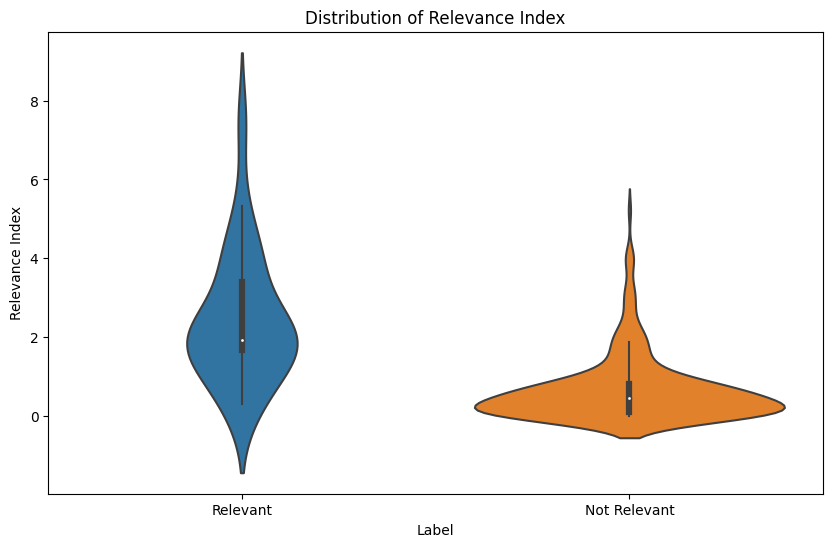

In [71]:
# obtain the relevance_index of YESs and NOs of the test data set and draw a violin plot
db_ranked_path = fpath.poten_litera_db_ranked
test_path = fpath.poten_litera_testing_set_300_read_index_corrected

df_db_ranked = pd.read_csv(db_ranked_path, header=0, sep=',')
df_db_ranked.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", 
                        "TITLE", "ABSTRACT", "KEYWORDS", 
                        "LENGTH_TAK", "LENGTH_TXT", "LENGTH_TEXT","RELEVANCE_INDEX"]

df_test = pd.read_csv(test_path, header=0, sep=',')
df_test.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS", "RELEVANT"]

relvant_index = []
relevant_relevance_index_list = []

non_relevant_index = []
non_relevant_relevance_index_list = []

for ind in df_test.index:
    index = int(df_test.at[ind, "INDEX"])
    # print(ind, index)
    # print(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "RELEVANCE_INDEX"].values[0])

    if df_test.at[ind, "RELEVANT"] == "YES" and df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "LENGTH_TEXT"].values[0] > 100:
        relvant_index.append(index)
        relevant_relevance_index_list.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "RELEVANCE_INDEX"].values[0])
    elif df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "LENGTH_TEXT"].values[0] > 100:
        non_relevant_index.append(index)
        non_relevant_relevance_index_list.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "RELEVANCE_INDEX"].values[0])
    else:
        pass

# print(len(relvant_index))
print("Numer of relevant literature:", len(relevant_relevance_index_list))
# print(len(non_relevant_index))
print("Number of not relevant literature:", len(non_relevant_relevance_index_list))

print()

# draw violin plot

# Combine the data for plotting
data = relevant_relevance_index_list + non_relevant_relevance_index_list
labels = ['Relevant'] * len(relevant_relevance_index_list) + ['Not Relevant'] * len(non_relevant_relevance_index_list)

# Create a DataFrame
df = pd.DataFrame({'Relevance Index': data, 'Label': labels})

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.violinplot(x='Label', y='Relevance Index', data=df)
plt.title('Distribution of Relevance Index')
plt.show()

<h3> Next step: manually read papers and find all actually related literature </h3>